In [21]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

from imblearn.over_sampling import SMOTENC

import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

In [22]:
# use custom function to get the corpus df, label dfs, and validation dfs
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [23]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)

In [24]:
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,two hussein ally hang iraqi official say
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [25]:
valence_df.head()

,valence,label
0,32,1
1,-48,0
2,26,1
3,40,1
4,-6,2


In [26]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


## Prepare Multilabel Classification Evaluation

In [27]:
def evaluate_multilabel_classification(lst, df, RNN=False):
    plt.figure(figsize=(15,20))
    subplot_num = 1
    
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    
    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        
        plt.subplot(3,2,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        accuracy = tp/(fp + tn + tp)
        accuracy_lst.append(1/accuracy)
        precision = tp/(fp + tp)
        precision_lst.append(1/precision)
        recall = tp/(tp + fn)
        recall_lst.append(1/recall)
        f1 = 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn))))
        f1_lst.append(1/f1)
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn)))))
        print('\n')
        
    micro_avg_accuracy = len(lst)/sum(accuracy_lst)
    micro_avg_precision = len(lst)/sum(precision_lst)
    micro_avg_recall = len(lst)/sum(recall_lst)
    micro_avg_f1 = len(lst)/sum(f1_lst)
    print('micro_avg_accuracy:', micro_avg_accuracy)
    print('micro_avg_precision:', micro_avg_precision)
    print('micro_avg_recall:', micro_avg_recall)
    print('micro_avg_f1:', micro_avg_recall)
        

## Classifier Chain Emotion Labels

In [30]:
X_train, X_test, y_train, y_test = train_test_split(corpus_df['text'], emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], random_state=3)


In [32]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_test


<313x2332 sparse matrix of type '<class 'numpy.float64'>'
	with 1138 stored elements in Compressed Sparse Row format>

In [33]:
nb_classifier = ClassifierChain(MultinomialNB(fit_prior=True))
lr_classifier = ClassifierChain(LogisticRegression(C=1e10, class_weight='balanced'))

nb_classifier.fit(tf_idf_X_train, y_train)
nb_train_preds = nb_classifier.predict(tf_idf_X_train)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

lr_classifier.fit(tf_idf_X_train, y_train)
lr_train_preds = lr_classifier.predict(tf_idf_X_train)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [34]:
# accuracy across labels
accuracy_score(y_test, lr_test_preds)

0.2523961661341853

In [40]:
CC_preds_df = pd.DataFrame(lr_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
CC_preds_df = pd.concat([CC_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.4981949458483754
anger_label precision: 0.8117647058823529
anger_label recall 0.7931034482758621
anger_label f1 0.8023255813953488


disgust_label accuracy: 0.35471698113207545
disgust_label precision: 0.6666666666666666
disgust_label recall 0.6619718309859155
disgust_label f1 0.6643109540636043


fear_label accuracy: 0.6415770609318996
fear_label precision: 0.8364485981308412
fear_label recall 0.8403755868544601
fear_label f1 0.8384074941451991


joy_label accuracy: 0.5402298850574713
joy_label precision: 0.7540106951871658
joy_label recall 0.7305699481865285
joy_label f1 0.7421052631578948


sadness_label accuracy: 0.6727272727272727
sadness_label precision: 0.8371040723981901
sadness_label recall 0.8295964125560538
sadness_label f1 0.8333333333333333


surprise_label accuracy: 0.8869257950530035
surprise_label precision: 0.916058394160584
surprise_label recall 0.8932384341637011
surprise_label f1 0.9045045045045046


micro_avg_accuracy: 0.5529905556128974
mic

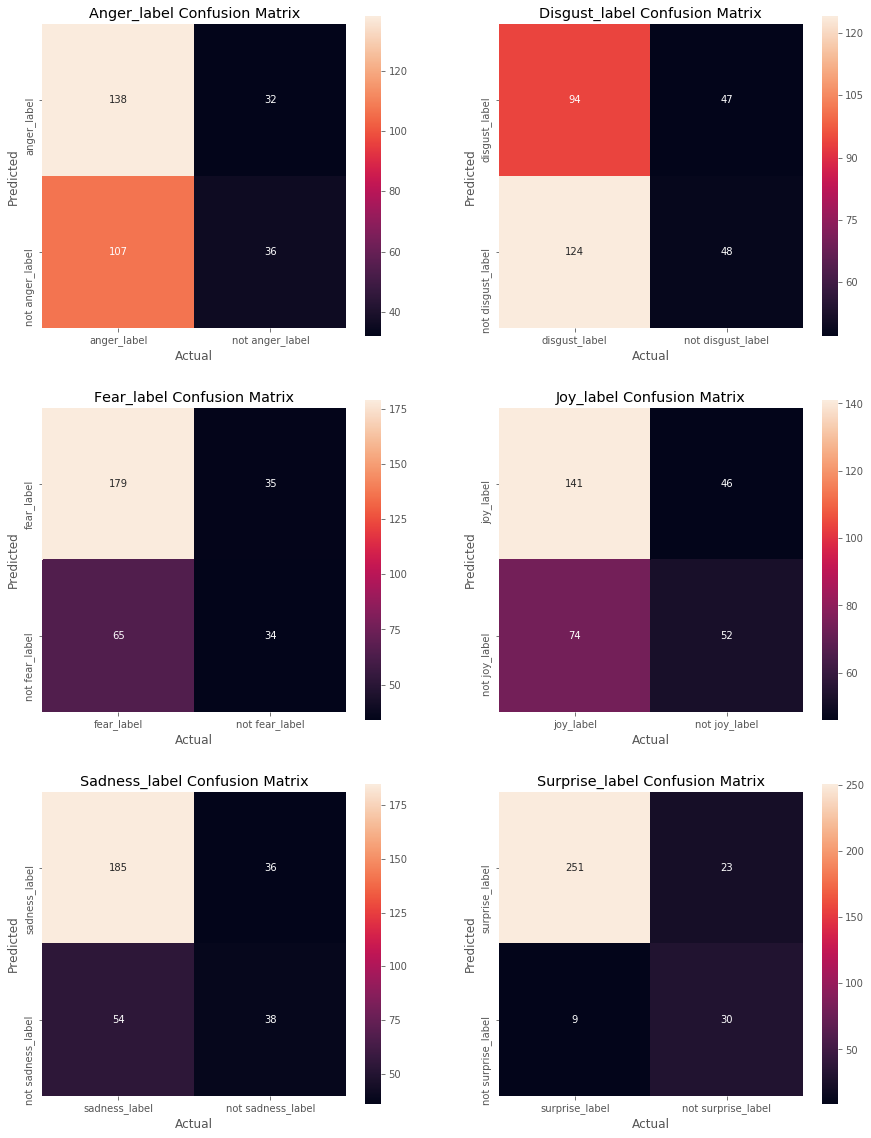

In [41]:
evaluate_multilabel_classification(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], CC_preds_df)

## Label Power Emotion Labels

In [45]:
nb_classifier = LabelPowerset(MultinomialNB(fit_prior=True))
lr_classifier = LabelPowerset(LogisticRegression(C=1e10, class_weight='balanced'))

nb_classifier.fit(tf_idf_X_train, y_train)
nb_train_preds = nb_classifier.predict(tf_idf_X_train)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

lr_classifier.fit(tf_idf_X_train, y_train)
lr_train_preds = lr_classifier.predict(tf_idf_X_train)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [50]:
LP_preds_df = pd.DataFrame(lr_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
LP_preds_df = pd.concat([LP_preds_df, y_reindex], axis=1)


In [51]:
LP_preds_df.head()

,pred_anger_label,pred_disgust_label,pred_fear_label,pred_joy_label,pred_sadness_label,pred_surprise_label,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,0,1,0,1,0,0,1,1,1,1
1,1,1,1,0,1,1,0,0,1,1,1,1
2,0,0,0,1,0,1,0,0,1,0,1,1
3,0,0,0,1,0,1,0,1,1,0,0,1
4,1,1,1,0,1,1,1,1,1,1,1,1


anger_label accuracy: 0.4889705882352941
anger_label precision: 0.7732558139534884
anger_label recall 0.764367816091954
anger_label f1 0.7687861271676302


disgust_label accuracy: 0.3522727272727273
disgust_label precision: 0.6642857142857143
disgust_label recall 0.6549295774647887
disgust_label f1 0.6595744680851063


fear_label accuracy: 0.6376811594202898
fear_label precision: 0.8461538461538461
fear_label recall 0.8262910798122066
fear_label f1 0.836104513064133


joy_label accuracy: 0.5419847328244275
joy_label precision: 0.7135678391959799
joy_label recall 0.7357512953367875
joy_label f1 0.7244897959183673


sadness_label accuracy: 0.6703296703296703
sadness_label precision: 0.8472222222222222
sadness_label recall 0.820627802690583
sadness_label f1 0.8337129840546698


surprise_label accuracy: 0.889273356401384
surprise_label precision: 0.9178571428571428
surprise_label recall 0.9145907473309609
surprise_label f1 0.9162210338680926


micro_avg_accuracy: 0.5497832590739424
micro_a

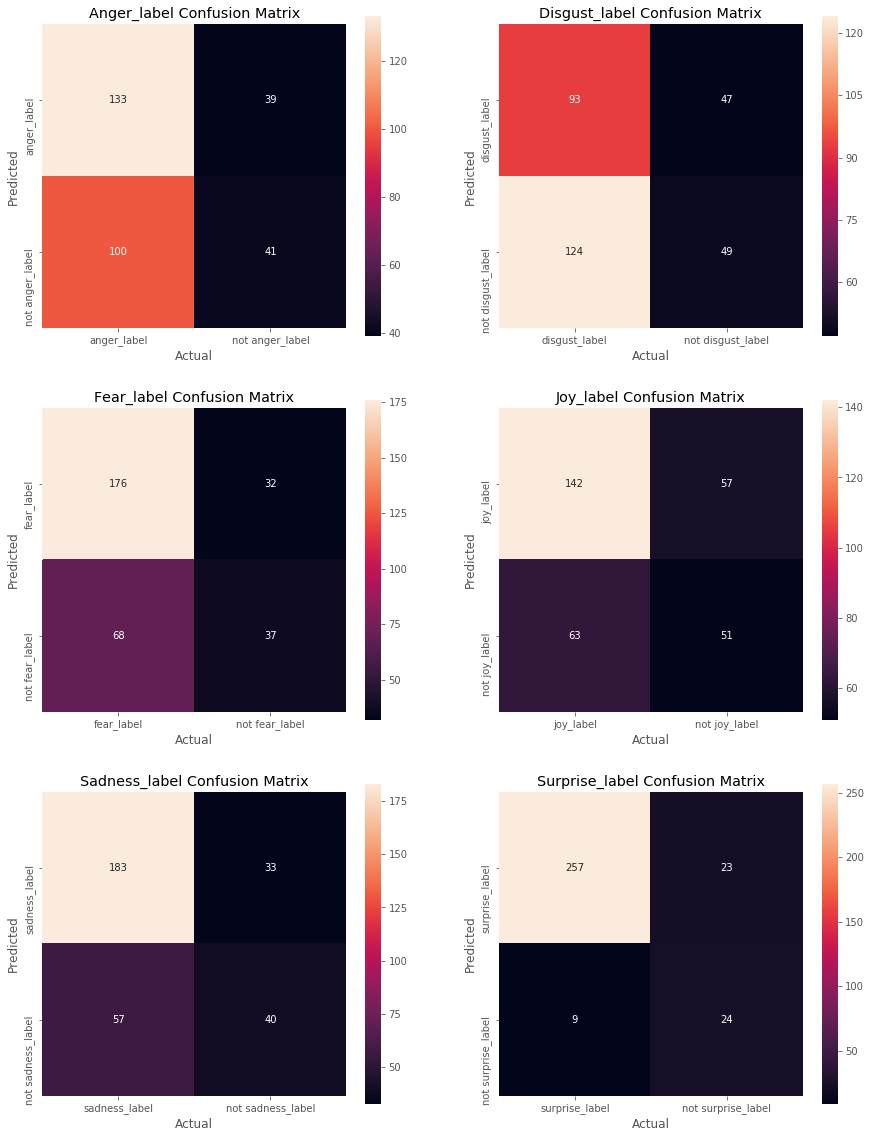

In [52]:
evaluate_multilabel_classification(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], LP_preds_df)


## RNN for Multilabel Classification

In [60]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)
            

In [69]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(corpus_df['text']))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=10)


In [70]:
threshold_labels_emotion.shape

(1250, 6)

In [71]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]
        

In [72]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, threshold_labels_emotion, test_size=0.2, random_state=42)

# labels multihot encoded
y_train_multihot = y_train.values
y_test_multihot = y_test.values

# USE SMOTENC to balance classes on the training set
# smt = SMOTENC(sampling_strategy='not majority', random_state=42, categorical_features=[0,1, 2,3,4,5,6,7,8,9])
# X_res, y_res = smt.fit_resample(X_train, y_train_onehot)

In [75]:
model = Sequential()

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=10, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train_multihot,
                    epochs=20,
                    batch_size=100,
                    class_weight=[{0: 3, 1: 1}, {0: 4, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
                    validation_data=(X_test, y_test_multihot))

Train on 1000 samples, validate on 250 samples
Epoch 1/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6888 - acc: 0.6180 - val_loss: 0.6364 - val_acc: 0.6827
Epoch 2/20
1000/1000 [==============================] - 0s 341us/step - loss: 0.4895 - acc: 0.7730 - val_loss: 0.5602 - val_acc: 0.7187
Epoch 3/20
1000/1000 [==============================] - 0s 335us/step - loss: 0.4145 - acc: 0.8270 - val_loss: 0.5463 - val_acc: 0.7307
Epoch 4/20
1000/1000 [==============================] - 0s 383us/step - loss: 0.3548 - acc: 0.8683 - val_loss: 0.5654 - val_acc: 0.7307
Epoch 5/20
1000/1000 [==============================] - 0s 400us/step - loss: 0.2970 - acc: 0.9060 - val_loss: 0.5626 - val_acc: 0.7433
Epoch 6/20
1000/1000 [==============================] - 0s 391us/step - loss: 0.2564 - acc: 0.9307 - val_loss: 0.5353 - val_acc: 0.7573
Epoch 7/20
1000/1000 [==============================] - 0s 378us/step - loss: 0.2119 - acc: 0.9503 - val_loss: 0.5646 - val_acc: 0.7507
Epo

250/250 [==============================] - 0s 236us/step


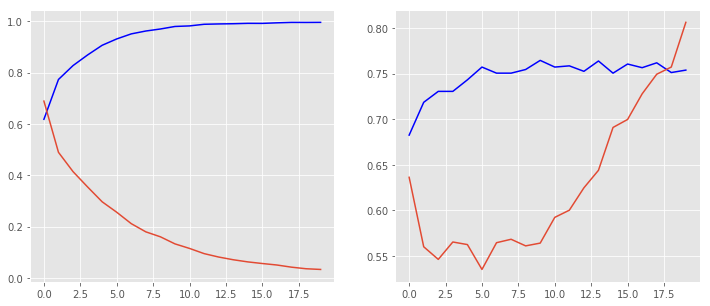

In [76]:
model.evaluate(X_test, y_test_multihot)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')

plt.subplot(1,2,2)
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')


In [80]:
model.save('RNN_multiclass_emotion.h5')

RNN_preds = model.predict_on_batch(X_test)

RNN_preds = pd.DataFrame({"pred_anger":RNN_preds[:,0], "pred_disgust":RNN_preds[:,1], "pred_fear":RNN_preds[:,2], "pred_joy":RNN_preds[:,3], "pred_sadness":RNN_preds[:,4], "pred_surprise":RNN_preds[:,5], "anger":y_test_multihot[:,0], "disgust":y_test_multihot[:,1], "fear": y_test_multihot[:,2], "joy": y_test_multihot[:,3], "sadness": y_test_multihot[:,4], "surprise": y_test_multihot[:,5]})
RNN_preds.loc[RNN_preds['disgust']==1]

,pred_anger,pred_disgust,pred_fear,pred_joy,pred_sadness,pred_surprise,anger,disgust,fear,joy,sadness,surprise
1,0.940450,0.763134,0.698302,0.234144,0.999369,0.996338,1,1,1,0,1,1
10,0.546485,0.839613,0.997988,0.002911,0.998818,0.980213,1,1,1,0,1,0
11,0.014720,0.827894,0.998883,0.988645,0.785883,0.999002,1,1,1,0,1,1
14,0.002063,0.299616,0.076703,0.567282,0.145992,0.980708,1,1,0,1,1,0
16,0.999259,0.999910,0.995722,0.148205,0.896691,0.418224,1,1,1,0,1,0
18,0.713881,0.031935,0.863294,0.012814,0.995421,0.858296,1,1,1,1,1,0
22,0.021792,0.593298,0.336936,0.319460,0.918669,0.960261,1,1,0,1,1,0
23,0.918193,0.006510,0.850027,0.019879,0.809881,0.999442,1,1,1,0,1,1
24,0.378816,0.222324,0.832896,0.996732,0.731046,0.998598,1,1,1,0,1,1
26,0.058930,0.649501,0.809824,0.970097,0.887094,0.998330,0,1,1,1,1,1


anger accuracy: 0.4840182648401826
anger precision: 0.8346456692913385
anger recall 0.7737226277372263
anger f1 0.803030303030303


disgust accuracy: 0.38317757009345793
disgust precision: 0.6949152542372882
disgust recall 0.6949152542372882
disgust f1 0.6949152542372882


fear accuracy: 0.5990783410138248
fear precision: 0.7975460122699386
fear recall 0.7975460122699386
fear f1 0.7975460122699386


joy accuracy: 0.5622119815668203
joy precision: 0.7349397590361446
joy recall 0.7870967741935484
joy f1 0.7601246105919003


sadness accuracy: 0.6681614349775785
sadness precision: 0.8324022346368715
sadness recall 0.8465909090909091
sadness f1 0.8394366197183099


surprise accuracy: 0.8706896551724138
surprise precision: 0.8820960698689956
surprise recall 0.9181818181818182
surprise f1 0.8997772828507796


micro_avg_accuracy: 0.5571614044003564
micro_avg_precision: 0.790863404207055
micro_avg_recall: 0.7972222499795377
micro_avg_f1: 0.7972222499795377


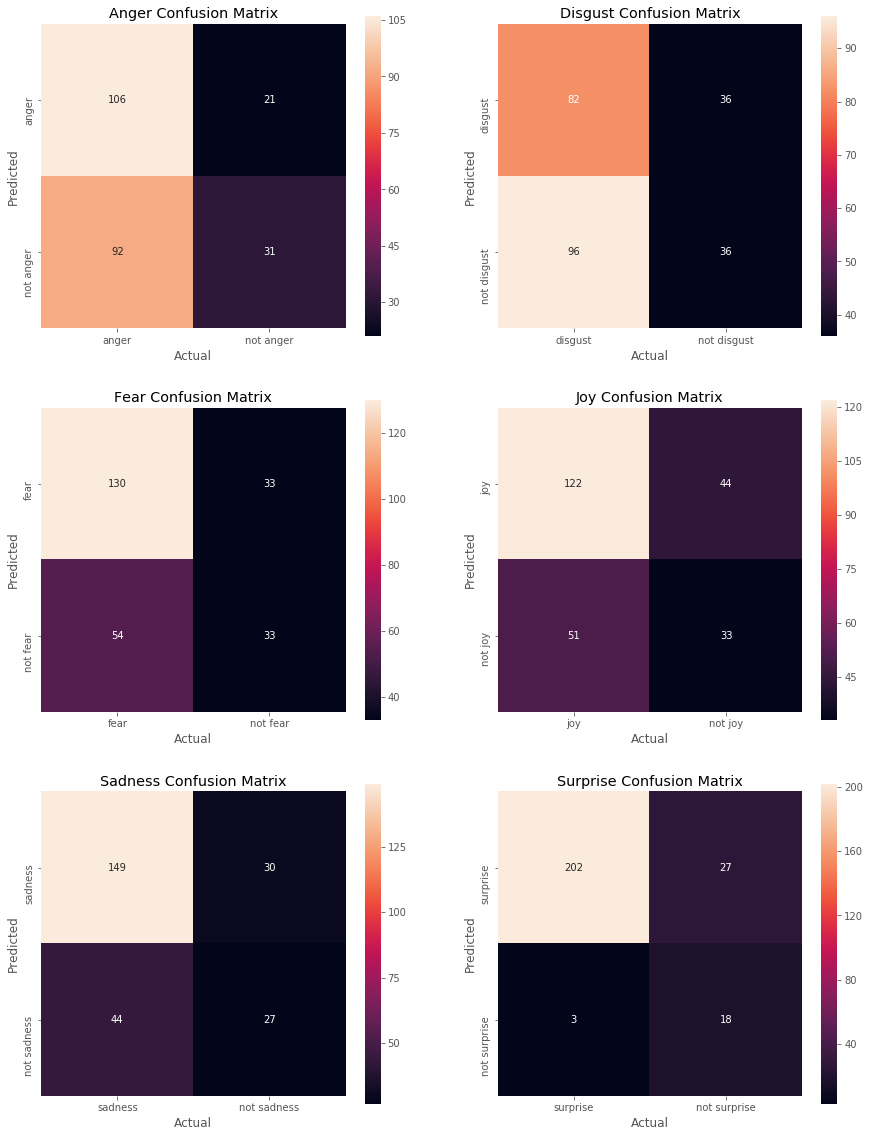

In [79]:
evaluate_multilabel_classification(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'], RNN_preds, RNN=True)